# [IAPR][iapr]: Lab 1 ‒  Image segmentation



**Mehrdad Kiani Oshtorjani (269424)**   
**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import time
import warnings
import skimage.io
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import img_as_ubyte
from skimage.morphology import (erosion, dilation, opening, closing, white_tophat)
from skimage.morphology import black_tophat, skeletonize, convex_hull_image 
from skimage.morphology import disk
from skimage.filters import sobel
from scipy.ndimage.morphology import binary_fill_holes
from skimage import morphology
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from scipy import ndimage
from skimage import exposure, feature,img_as_float
from scipy import ndimage

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

/tmp/ipykernel_203/4228159519.py:16: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_fill_holes


---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

# 1.1 Brain image visualization

We load the image and show it.

(256, 256)
<class 'tuple'>


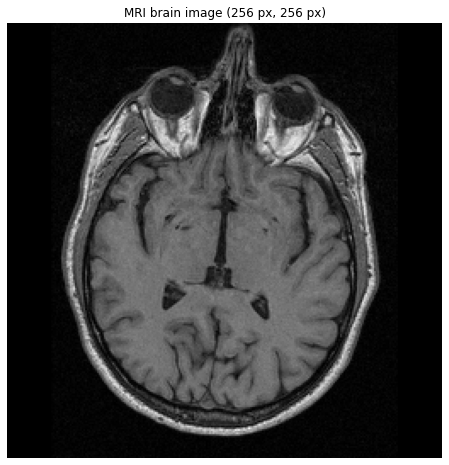

In [2]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

print(brain_im.shape)
print(type(brain_im.shape))

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

# 1.2 Region growing (5pts)

We display the image in the original format.

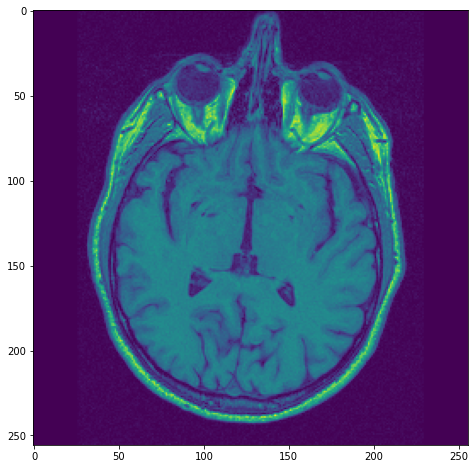

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.imshow(brain_im)
plt.show()

## 1.2.1 pre-processing

Before applying different methods on the CT scans, we perform a pre-processing step in order to remove the noise from the image. For that purpose we use the median filter, because **we like it very much**.

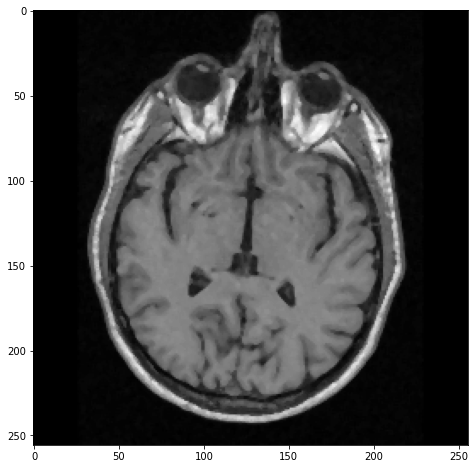

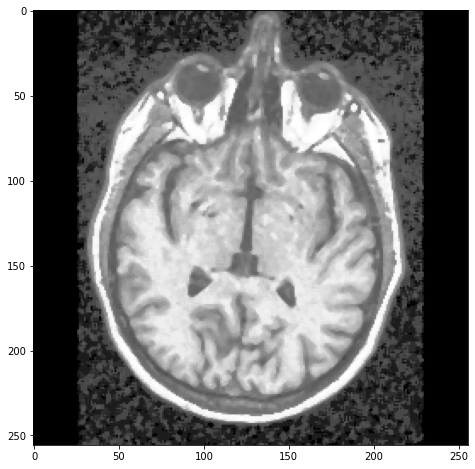

In [4]:
brain_im_filter_median = cv2.medianBlur(brain_im,3) 
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.imshow(brain_im_filter_median, cmap='gray')
plt.show()

brain_im_filter_equalizer= cv2.equalizeHist(brain_im_filter_median) 
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.imshow(brain_im_filter_equalizer, cmap='gray')
plt.show()

We define a function *get_nbhd* to define the pixels where it is necessary to add neighboring pixels/voxels. It accepts the current voxel (pt), the indicator array of checked points (checked), and the dimensions of the volume (img.shape). 
The checked indicator is necessary so we don’t add points that have already been checked. The volume dimensions argument is necessary so we don’t add points beyond the image borders.

In [5]:
def get_nbhd(pt, checked, dims):
    nbhd = []

    if (pt[0] > 0) and not checked[pt[0]-1, pt[1]]:
        nbhd.append((pt[0]-1, pt[1]))
    if (pt[1] > 0) and not checked[pt[0], pt[1]-1]:
        nbhd.append((pt[0], pt[1]-1))

    if (pt[0] < dims[0]-1) and not checked[pt[0]+1, pt[1]]:
        nbhd.append((pt[0]+1, pt[1]))
    if (pt[1] < dims[1]-1) and not checked[pt[0], pt[1]+1]:
        nbhd.append((pt[0], pt[1]+1))

    return nbhd

We show the size of the image

In [6]:
brain_im.shape

(256, 256)

We then define a function named *grow* that

A point might be placed in the stack multiple times before its checked. So, if the point has already been checked, we add a check to just continue to the next iteration of the while loop. We handle the special cases at the borders with an ugly six lines of code (imin, imax, etc.). Next, there is a connectivity choice for adding neighbors of a voxel, i.e., the choice of which voxels are considered the neighbors of a given voxel. This is determined by the get_nbhd function and should not be confused with the neighborhood that is used for computing the average image value about a voxel (the latter usually being a comparatively larger region). Rather, this neighborhood defines the coordinates (i.e., voxels) that are adjacent to a given coordinate. There are different ways to define the neighborhood on a 3D lattice, and I use a 4-voxel neighborhood in the code below:

In [7]:
def grow(img, seed, t):

    seg = np.zeros(img.shape, dtype=np.bool)
    checked = np.zeros_like(seg)            #Return an array of zeros with the same shape and type as a given array.


    seg[seed] = True
    checked[seed] = True
    needs_check = get_nbhd(seed, checked, img.shape)
    area = 0
    while len(needs_check) > 0:
        pt = needs_check.pop()

        # Its possible that the point was already checked and was
        # put in the needs_check stack multiple times.
        if checked[pt]: continue

        checked[pt] = True

        # Handle borders.
        imin = max(pt[0]-t, 0)
        imax = min(pt[0]+t, img.shape[0]-1)
        jmin = max(pt[1]-t, 0)
        jmax = min(pt[1]+t, img.shape[1]-1)
        
        area = area + 1
        
        if img[pt] >= img[imin:imax+1, jmin:jmax+1].mean():
            # Include the voxel in the segmentation and
            # add its neighbors to be checked.
            seg[pt] = True
            needs_check += get_nbhd(pt, checked, img.shape)
            
    return seg, area

Let's test the python implementation on the MRI image.

Elapsed time: 0.238 seconds.


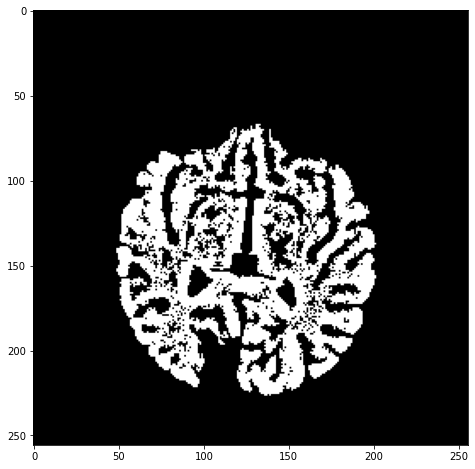

In [8]:
warnings.filterwarnings('ignore')
seed = (120,120) 
start = time.time()
seg, area = grow(brain_im, seed, 7)
stop = time.time()
print("Elapsed time: %.3f seconds." % (stop - start))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.imshow(seg, cmap='gray')
plt.show()

In [9]:
print('The total number of pixels in the image is of {} pixels.'.format(np.size(seg)))
print('The area of the brain is {} pixels.'.format(area))

The total number of pixels in the image is of 65536 pixels.
The area of the brain is 15373 pixels.


Additionally, we can apply some morphological operations to our output to make it smoother. For example we can apply a dilation to fill the holes in the middle of the brain.

In [10]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 10), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

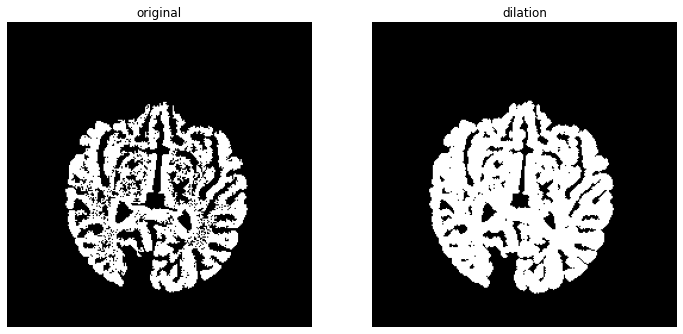

In [11]:
footprint = disk(1)
dilated = dilation(seg, footprint)
plot_comparison(seg, dilated, 'dilation')

This result shows that with a small dilation we fill the holes inside the brain, but at the same time we reduce the resolution in the borders, which reduce the sharpness of the method. For sure it is necessary to tune this method and include maybe other techniques to fill the holes in the middle, without losing sharpness.

# 1.3 Contour detection (5pts)

We use the classic Sobel edge detection method.

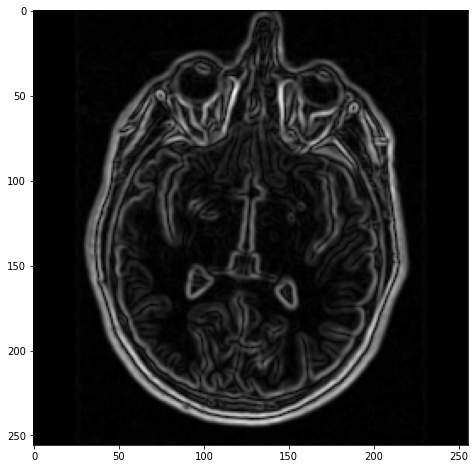

In [12]:
Gaussian_im = cv2.GaussianBlur(brain_im, (5,5), 0)
sobel_im=sobel(Gaussian_im)
ret,threshold = cv2.threshold(sobel_im,0.025,255,0)
objects = binary_fill_holes(threshold).astype(np.uint8)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(sobel_im,cmap=plt.cm.gray)

We complement this technique with the use of region properties, a tool that allows to define regions inside a binary image based on the connection between pixels. For that we use the function *remove_small_objects* that allows to delete objects smaller than a threshold. Based on the size of the brain we used a threshold of 1000 px. We also use the function *morphologyEx* to open the image.

The area of the brain is 16795 pixels.


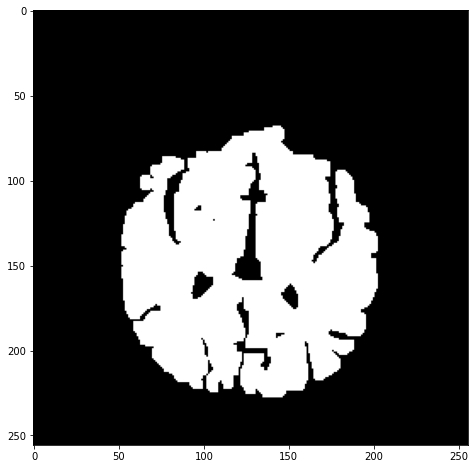

In [13]:
ret,threshold = cv2.threshold(sobel_im,0.025,255,cv2.THRESH_BINARY) 
my_brain = morphology.remove_small_objects((objects*255-threshold).astype(bool), min_size=1000)
kernel = np.ones((2,2),np.uint8) 
just_brain = cv2.morphologyEx(my_brain.astype(np.uint8), cv2.MORPH_DILATE,kernel, iterations =4)
print('The area of the brain is {} pixels.'.format(np.count_nonzero(just_brain)))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(just_brain,cmap=plt.cm.gray)

# 1.4 Additional method (5pts)

We propose to use two additional methods: active contour model and LOG or Laplacian of Gaussian.

## 1.4.1 Active contour model

The [active contour model](https://www.analyticsvidhya.com/blog/2021/09/active-contours-a-method-for-image-segmentation-in-computer-vision/) is a method to fit open or closed splines to lines or edges in an image 

It works by minimizing an energy that is in part defined by the image and part by the spline’s shape: length and smoothness. The minimization is done implicitly in the shape energy and explicitly in the image energy. It is a segmentation method that uses energy forces and constraints to separate the pixels of interest from a picture for further processing and analysis. The method is defined as an active model for the segmentation process.


Here we approximate the shape of the brain as a combination of sines and cosines.

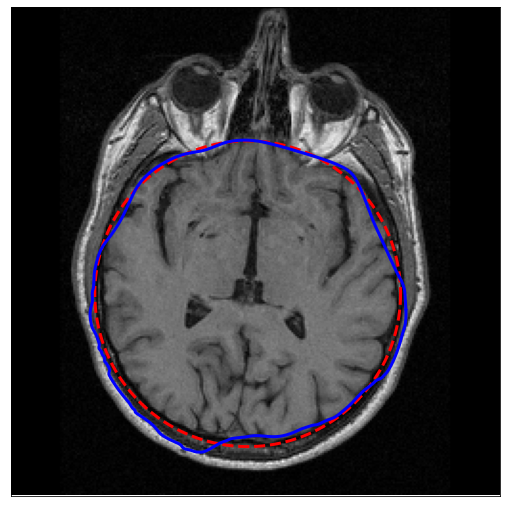

In [14]:
s = np.linspace(0, 2*np.pi, 500)
r = 150 + 80*np.sin(s) # y direction
c = 124 + 80*np.cos(s) # x direction
init = np.array([r, c]).T

# We compute the active contour approximation.
snake = active_contour(gaussian(brain_im, 2, preserve_range=False),
                       init, alpha=0.025, beta=10, gamma=0.001)

# We plot the result with the original constrain.
fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(brain_im, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, brain_im.shape[1], brain_im.shape[0], 0])

plt.show()

Based on the approximation made with the contour, we can obtain a value for the size of the brain.

In [15]:
x = snake[:,0]
y = snake[:,1]
area = 0.5*np.sum(y[:-1]*np.diff(x) - x[:-1]*np.diff(y))
area = np.abs(area)
print('The area of brain is {}'.format(int(area)))

The area of brain is 20277


## 1.4.2. Laplacian of Gaussian

The [Laplacian of Gaussian (LoG)](https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm) is a 2-D isotropic measure of the 2nd spatial derivative of an image. The Laplacian of an image highlights regions of rapid intensity change and is therefore often used for edge detection. The Laplacian is often applied to an image that has first been smoothed with something approximating a Gaussian smoothing filter in order to reduce its sensitivity to noise, and hence the two variants will be described together here. The operator normally takes a single graylevel image as input and produces another graylevel image as output.


Here we combine the use of LoG with the region approach used before. We manually select the biggest region in the image, since we have this information from the beginning.

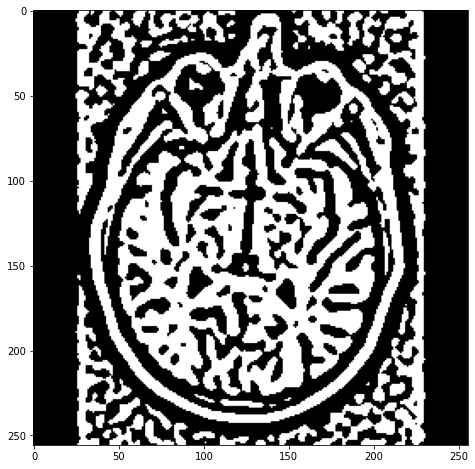

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8));
log_brain_im = ndimage.gaussian_laplace(img_as_float(brain_im), sigma=2.4)
log_brain_im=log_brain_im<0.0
ax.imshow(log_brain_im,cmap='gray')

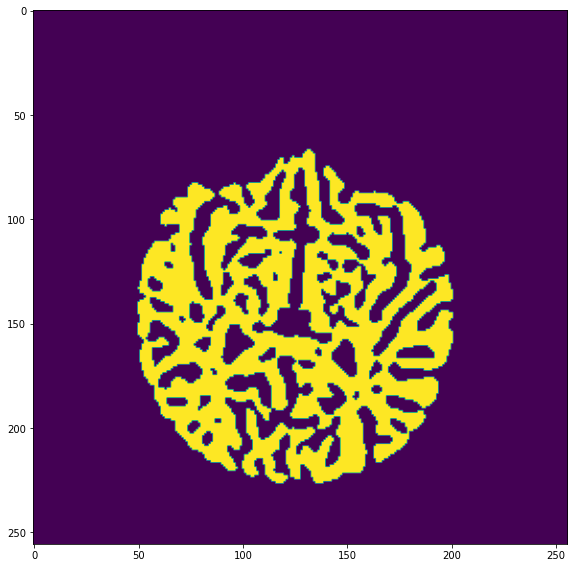

In [17]:
label_image = label(log_brain_im)
regions = regionprops(label_image)
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(label_image==35)
plt.tight_layout()
plt.show()

After we isolate the brain and plot it, we can count the number of pixels.

In [18]:
print('The area of the brain is {} pixels.'.format(np.count_nonzero(label_image==35)))


The area of the brain is 11975 pixels.


Based on the results obtained, we can see that each method throws a different result, depending on what we define as brain. Depending on the computation capacity, the available time for the analysis and the precision we want, we must choose which combination of functions we should use. 
Clearly there is no unique answer without a precise definition of what we need to calculate. However, we estimate that the last method we implemented (LoG + region props.) could be the most precise among all the combinations we used.

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

## 2.0 Preparation
We import packages and define all the functions that we will use for solving the problem.

Importing packages.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
from skimage.io import imread, imshow
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
import tarfile
import os
import cv2
%matplotlib inline 

We define all the functions to be used. The most complex functions have comments explaining in detail how they work.

In [20]:
def shapeandpixelcount(contours, outputf):
    
    count = []
    for x in contours:
    #function to find objects has contours of them in the image  
        area = cv2.contourArea(x)
        count.append(x)
    
    all_pts = []
    for c in count:
        c_pts = []
        for x in range(outputf.shape[0]):
            for y in range(outputf.shape[1]):
                #function that check if a pixel inside a contour or not. It return positive for values inside the contour
                #and returns 0 value if pixel is on the edge
                ppt = cv2.pointPolygonTest(c, (y,x), False)
                if ppt >= 0:
                    c_pts.append((y,x))
        all_pts.append(c_pts)

    pix_count=sum([len(ele) for ele in all_pts])  

    return pix_count, len(count)

In [21]:
def split_black(img): 

    # Brightness adjustment depending on the threshold through mean value of the V channel in HSV color space
    hsvimg_dark = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    mn_hsv = np.mean(hsvimg_dark[:,:,2])
    
    if (mn_hsv <= 125):
        hsvimg_dark[:,:,2] = hsvimg_dark[:,:,2] *1.5
    elif (mn_hsv > 190):
        hsvimg_dark[:,:,2] = hsvimg_dark[:,:,2] *0.8
    
    #BGR image is to be used for contour drawing
    fi_dark=cv2.cvtColor(hsvimg_dark,cv2.COLOR_HSV2BGR)

    #splitting HSV color space components (Hue, Saturation, Value)
    h, s, v = cv2.split(hsvimg_dark)
    

    #Defining brightness coefficient by getting mean of an image to be used as a mask
    brightness_coeff = cv2.mean(hsvimg_dark)[2] / 255 
    
    #Adjusting upper boundaries for saturation(s) and value(v) channels depending on the brightness coefficient 
    dark_s = int(120*brightness_coeff)
    dark_v = int(175*brightness_coeff)
    
    #lower boundary is set to zero for all channels
    dark_lwr = np.array([0,0,0])
    #upper boundary for hue value is set to upper limit since in cv it is 360//2
    #upper boundary for saturation is set to
    #upper boundary for value is set to 
    dark_upr = np.array([179,dark_s,dark_v])
    
    #inRange function is used to find the pixels lie between lower and upper boundaries of the image in HSV color space
    #to be applied them as mask
    mask_dark = cv2.inRange(cv2.cvtColor(fi_dark, cv2.COLOR_BGR2HSV), dark_lwr, dark_upr)
    
    #creating points to check neighbouring pixels around a pixel to apply closing and opening
    kernel = np.ones((7,7),np.uint8)
    #using morphologyEx function apply closing on neighboring points to close small holes inside the foreground objects
    mask_dark = cv2.morphologyEx(mask_dark, cv2.MORPH_CLOSE, kernel)
    #using morphologyEx function apply opening on neighboring points
    mask_dark = cv2.morphologyEx(mask_dark, cv2.MORPH_OPEN, kernel)
    
    #drawing contours of the objects on masked image
    contours_dark, hierarchy = cv2.findContours(mask_dark, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #mask_dark is the image masked for black shapes
    #cv2.RETR_EXTERNAL allows to have only to have the extreme contour that is eldest in the hierarchy, so extracting only the
    #outer contours
    
    #cv2.CHAIM_APPROX_SIMPLE is the algortihm for contour detection
    #The CHAIN_APPROX_SIMPLE  algorithm compresses horizontal, vertical, and diagonal segments along the contour and leaves only
    #their end points. This means that any of the points along the straight paths will be dismissed, and we will be left with 
    #only the end points. For example, consider a contour, along a rectangle. All the contour points, except the four corner 
    #points will be dismissed. This method is faster than the CHAIN_APPROX_NONE because the algorithm does not store all the 
    #points, uses less memory, and therefore, takes less time to execute.
    
    #drawing contours of black shapes on BGR image 
    outputf_dark = cv2.drawContours(fi_dark, contours_dark, -1, (255, 0, 255), -1)
    #fidark is image for drawing
    #contours_dark is the contours in the previous line
    #-1 stands for drawing contours on all objects
    #(255, 0, 255) is the color for drawing
    #-1 stands for filling the objects if it is 0 and greater it draw contours on the inside points of image and going up
    # increases the thickness of the contour line
    
    return contours_dark, outputf_dark

In [22]:
def split_blue(img):

    hsvimg_blue = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    mn_hsv = np.mean(hsvimg_blue[:,:,2])
    
    if (mn_hsv <= 125):
        hsvimg_blue[:,:,2] = hsvimg_blue[:,:,2] *1.5
    elif (mn_hsv > 190):
        hsvimg_blue[:,:,2] = hsvimg_blue[:,:,2] *0.7
    
    fi_blue=cv2.cvtColor(hsvimg_blue,cv2.COLOR_HSV2BGR)
    
    hsvimg_blue = cv2.cvtColor(fi_blue, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsvimg_blue)
    
    min_val, max_val, min_indx, max_indx = cv2.minMaxLoc(v)
    brightness_coeff = cv2.mean(hsvimg_blue)[2] / 255 
    
    blue_s = int(120*brightness_coeff)
    blue_v = int(180*brightness_coeff)
    
    blue_lwr = np.array([90,blue_s-50,blue_v-50])
    blue_upr = np.array([130,255,255])
    
    mask_blue = cv2.inRange(cv2.cvtColor(fi_blue, cv2.COLOR_BGR2HSV), blue_lwr, blue_upr)    
    kernel = np.ones((7,7),np.uint8)

    mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_CLOSE, kernel)
    mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_OPEN, kernel)
    
    contours_blue, hierarchy = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    outputf_blue = cv2.drawContours(fi_blue, contours_blue, -1, (0, 0, 255), -1)
    
    return contours_blue, outputf_blue

In [23]:
def split_black_i1(img):

    hsvimg_dark = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    mn_hsv = np.mean(hsvimg_dark[:,:,2])
    
    if (mn_hsv <= 125):
        hsvimg_dark[:,:,2] = hsvimg_dark[:,:,2] *1.5
    elif (mn_hsv > 190):
        hsvimg_dark[:,:,2] = hsvimg_dark[:,:,2] *0.8
    
    fi_dark=cv2.cvtColor(hsvimg_dark,cv2.COLOR_HSV2BGR)
     
    h, s, v = cv2.split(hsvimg_dark)
    
    brightness_coeff = cv2.mean(hsvimg_dark)[2] / 255 
    
    dark_s = int(150*brightness_coeff)
    dark_v = int(220*brightness_coeff)
    
    
    dark_lwr = np.array([0,0,0])
    dark_upr = np.array([179,dark_s,dark_v])
    
    mask_dark = cv2.inRange(cv2.cvtColor(fi_dark, cv2.COLOR_BGR2HSV), dark_lwr, dark_upr)
    
    kernel = np.ones((7,7),np.uint8)
    mask_dark = cv2.morphologyEx(mask_dark, cv2.MORPH_CLOSE, kernel)
    mask_dark = cv2.morphologyEx(mask_dark, cv2.MORPH_OPEN, kernel)
    
    contours_dark, hierarchy = cv2.findContours(mask_dark, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
    outputf_dark = cv2.drawContours(fi_dark, contours_dark, -1, (255, 0, 255), -1)

    return contours_dark, outputf_dark

In [24]:
def split_blue_i1(img):
       
    hsvimg_blue = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    mn_hsv = np.mean(hsvimg_blue[:,:,2])
    
    if (mn_hsv <= 125):
        hsvimg_blue[:,:,2] = hsvimg_blue[:,:,2] *1.5
    elif (mn_hsv > 190):
        hsvimg_blue[:,:,2] = hsvimg_blue[:,:,2] *0.7
    
    fi_blue=cv2.cvtColor(hsvimg_blue,cv2.COLOR_HSV2BGR)

    h, s, v = cv2.split(hsvimg_blue)
    
    min_val, max_val, min_indx, max_indx = cv2.minMaxLoc(v)
    brightness_coeff = cv2.mean(hsvimg_blue)[2] / 255
    
    blue_s = int(80*brightness_coeff)
    blue_v = int(190*brightness_coeff)
    
    blue_lwr = np.array([90,blue_s-35,blue_v-35])
    blue_upr = np.array([130,255,255])
    
    mask_blue = cv2.inRange(cv2.cvtColor(fi_blue, cv2.COLOR_BGR2HSV), blue_lwr, blue_upr)    
    kernel = np.ones((7,7),np.uint8)
    mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_CLOSE, kernel)
    mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_OPEN, kernel)

    
    contours_blue, hierarchy = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    outputf_blue = cv2.drawContours(fi_blue, contours_blue, -1, (0, 0, 255), -1)
            
    return contours_blue, outputf_blue

In [25]:
def split_black_i2(img):
 
    hsvimg_dark = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    mn_hsv = np.mean(hsvimg_dark[:,:,2])
    
    if (mn_hsv <= 125):
        hsvimg_dark[:,:,2] = hsvimg_dark[:,:,2] *1.5
    elif (mn_hsv > 190):
        hsvimg_dark[:,:,2] = hsvimg_dark[:,:,2] *0.8
    
    fi_dark=cv2.cvtColor(hsvimg_dark,cv2.COLOR_HSV2BGR)
 
    h, s, v = cv2.split(hsvimg_dark)
    
    brightness_coeff = cv2.mean(hsvimg_dark)[2] / 255 
    
    dark_s = int(115*brightness_coeff)
    dark_v = int(165*brightness_coeff)
    
    dark_lwr = np.array([0,0,0])
    dark_upr = np.array([179,dark_s,dark_v])

    mask_dark = cv2.inRange(cv2.cvtColor(fi_dark, cv2.COLOR_BGR2HSV), dark_lwr, dark_upr)

    kernel = np.ones((7,7),np.uint8)
    mask_dark = cv2.morphologyEx(mask_dark, cv2.MORPH_CLOSE, kernel)
    mask_dark = cv2.morphologyEx(mask_dark, cv2.MORPH_OPEN, kernel)
    
    contours_dark, hierarchy = cv2.findContours(mask_dark, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    outputf_dark = cv2.drawContours(fi_dark, contours_dark, -1, (255, 0, 255), -1)
    
    return contours_dark, outputf_dark

In [26]:
def split_blue_i2(img):   
    
    hsvimg_blue = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    mn_hsv = np.mean(hsvimg_blue[:,:,2])
    
    if (mn_hsv <= 125):
        hsvimg_blue[:,:,2] = hsvimg_blue[:,:,2] *1.5
    elif (mn_hsv > 190):
        hsvimg_blue[:,:,2] = hsvimg_blue[:,:,2] *0.7
    
    fi_blue=cv2.cvtColor(hsvimg_blue,cv2.COLOR_HSV2BGR)

    h, s, v = cv2.split(hsvimg_blue)
    
    min_val, max_val, min_indx, max_indx = cv2.minMaxLoc(v)
    brightness_coeff = cv2.mean(hsvimg_blue)[2] / 255 
    
    blue_s = int(95*brightness_coeff)
    blue_v = int(190*brightness_coeff)
    
    blue_lwr = np.array([90,blue_s-30,blue_v-30])
    blue_upr = np.array([130,255,255])
    
    mask_blue = cv2.inRange(cv2.cvtColor(fi_blue, cv2.COLOR_BGR2HSV), blue_lwr, blue_upr)    
    kernel = np.ones((7,7),np.uint8)
    mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_CLOSE, kernel)
    mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_OPEN, kernel)
    
    contours_blue, hierarchy = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    outputf_blue = cv2.drawContours(fi_blue, contours_blue, -1, (0, 0, 255), -1)
    
    return contours_blue, outputf_blue

### 2.1 Visualization

We import the packages to be used for this Problem.

We load the images and display some basic information

In [27]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


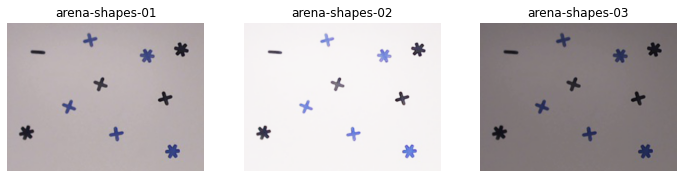

In [28]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

We read and make copies of the images.

In [29]:
i0 = cv2.imread(filenames[0])
i1 = cv2.imread(filenames[1])
i2 = cv2.imread(filenames[2])
#Dimension of the images
height = i0.shape[0]
width = i0.shape[1]
#Copying original images for each illumination for black and blue shapes 
i0_dark=i0.copy()
i0_blue=i0.copy()
i1_dark=i1.copy()
i1_blue=i1.copy()
i2_dark=i2.copy()
i2_blue=i2.copy()

#### Steps to follow:
1. Convert BGR images (imported by cv2 module as BGR) to HSV color space since color channels in BGR do not allow us to recgonize separation of black and blue colors. This operation is done through Value Channel of HSV color space. Then mean brightness of the HSV images is calculated to change the brightness of the image depending on the mean value relative to threshold that defined. Afterwards, mean value is multiplied with the coefficient and new Value Channel value is assigned on the image.

2. Second step is to define a mask to be applied on the image, this is done through selecting pixels between lower and upper boundary of the HSV color space in all channels that again brightness coefficient is employed for this purpose which is found through mean value of value channel. Then this brightness coefficient is multiplied for reference values which are different for each image and resulted in upper boundaries for saturation and value Channels. Upper boundary value of hue channel is set as 179 for dark images and 130 for blue images since this is a reference value for the color. Lower boundary of black color is set to 0 since it includes components in this range. Lower boundaries of blue color differentiates except for hue channel. The reason of change for saturation and value channel can be explained via illumination is not adjusted perfectly during preprocessing even though preprocessing seems to result in very similar images for image 1 and 3. It should be noted that the reason of difference for second image in above is the exposure difference. This was tried to be solved by using histogram equalization or using adaptive histogram equalization via exposure module from skimage, however, desired results could not be achieved. Thus, usig a mask depending on the brightness coefficient for each image lead to reasonable results. Finally, inRange function is used to find the pixels lie between lower and upper boundaries of the image in HSV color space.

3. Third step is to create points to check neighbouring pixels around a pixel to apply closing and opening. This is done by creating 8x8 matrix. Morphology module is employed for closing which closes the small holes inside the shapes and for opening which allows to remove noise on neighborinng points. Following that contours of the shapes are found on the masked image by using findcontours function. Finally, these contours are drawn on for each BGR images defined for each image.


Number of shapes are calculated by shapeandpixelcount() function which uses the contours and image that has contours drawn on it as input and count the objects through function from cv2 module.

Note: Detailed explanation of each function and operation can be seen in the cell of split_black() function. Since the operations are same and only difference is brightness coefficients and lower, upper boundaries for each color, explanations are done in split_black() not to cause crowd in the Notebook.

In [30]:
#Contours and images that include contour on them for each color on each images that is called through 6 functions since 
#each image has different brightness coefficient and lower and upper boundary to pick the pixels
contours_dark_0, outputf_dark_0=split_black(i0_dark)
contours_blue_0, outputf_blue_0=split_blue(i0_blue)
contours_dark_1, outputf_dark_1=split_black_i1(i1_dark)
contours_blue_1, outputf_blue_1=split_blue_i1(i1_blue)
contours_dark_2, outputf_dark_2=split_black_i2(i2_dark)
contours_blue_2, outputf_blue_2=split_blue_i2(i2_blue)

In [31]:
#Pixel and shape count calling for blue objects in the images
pxlblue1, shpblue1 = shapeandpixelcount(contours_blue_0, outputf_blue_0)
pxlblue2, shpblue2 = shapeandpixelcount(contours_blue_1, outputf_blue_1)
pxlblue3, shpblue3 = shapeandpixelcount(contours_blue_2, outputf_blue_2)

In [32]:
#Pixel and shape count calling for black objects in the images
pxlblck1, shpblck1 = shapeandpixelcount(contours_dark_0, outputf_dark_0)
pxlblck2, shpblck2 = shapeandpixelcount(contours_dark_1, outputf_dark_1)
pxlblck3, shpblck3 = shapeandpixelcount(contours_dark_2, outputf_dark_2)

We plot the images with the number of shapes of each color in them.

Number of black shapes detected in image 1 = 5
Number of blue shapes detected in image 1 = 5


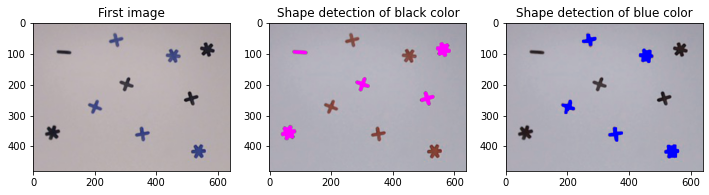

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(images[0])
ax[0].set_title("First image")
ax[1].imshow(outputf_dark_0)
ax[1].set_title("Shape detection of black color")
ax[2].imshow(outputf_blue_0)
ax[2].set_title("Shape detection of blue color")
print("Number of black shapes detected in image 1 =", shpblck1)
print("Number of blue shapes detected in image 1 =", shpblue1)

Number of black shapes detected in image 2 = 5
Number of blue shapes detected in image 2 = 5


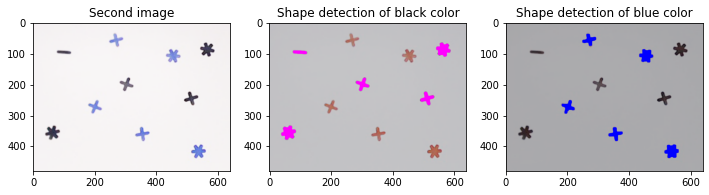

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(images[1])
ax[0].set_title("Second image")
ax[1].imshow(outputf_dark_1)
ax[1].set_title("Shape detection of black color")
ax[2].imshow(outputf_blue_1)
ax[2].set_title("Shape detection of blue color")
print("Number of black shapes detected in image 2 =", shpblck2)
print("Number of blue shapes detected in image 2 =", shpblue2)

Number of blue shapes detected in image 3 = 5
Number of black shapes detected in image 3 = 5


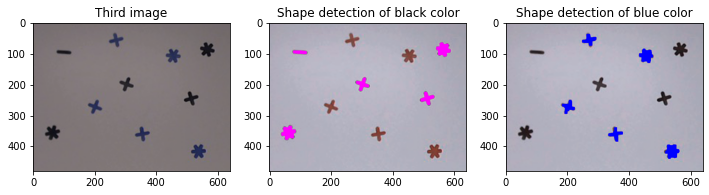

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(images[2])
ax[0].set_title("Third image")
ax[1].imshow(outputf_dark_2)
ax[1].set_title("Shape detection of black color")
ax[2].imshow(outputf_blue_2)
ax[2].set_title("Shape detection of blue color")
print("Number of blue shapes detected in image 3 =", shpblue3)
print("Number of black shapes detected in image 3 =", shpblck3)

### 2.3 Total area (in pixels) of each color (5 pts)

The number of pixels of each color is also computed with the same function that counts the number of shapes of each color.

In [36]:
#Calling numer of pixels for each color
print("Number of black pixels detected in image 1 =", pxlblck1)
print("Number of blue pixels detected in image 1 =", pxlblue1)
print("Number of black pixels detected in image 2 =", pxlblck2)
print("Number of blue pixels detected in image 2 =", pxlblue2)
print("Number of black pixels detected in image 3 =", pxlblck3)
print("Number of blue pixels detected in image 3 =", pxlblue3)

Number of black pixels detected in image 1 = 5089
Number of blue pixels detected in image 1 = 5820
Number of black pixels detected in image 2 = 4913
Number of blue pixels detected in image 2 = 5405
Number of black pixels detected in image 3 = 5057
Number of blue pixels detected in image 3 = 5837


Pixels are counted in shapeandpixelcount() function which employs input as contours and image has contours drawn on it. For this purpose cv2.pointPolygonTest() function is used where all pixels in the image is checked if they are inside the contour or no. If they the function gives positive output, pixels append to the relative shape. It is possible to have pixel of each shape as well.